# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
import time 

# Load the data

In [2]:
df = pd.read_csv("../data_preprocessing/data.csv")
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23462 entries, 0 to 23461
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       23462 non-null  int64         
 1   date        23462 non-null  datetime64[ns]
 2   Text        23462 non-null  object        
 3   Clean_text  23462 non-null  object        
 4   Verdict     23462 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 916.6+ KB


# Train-test split


In [3]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# TF-idf

In [4]:
vectorizer = TfidfVectorizer(max_df=0.6, stop_words='english')
X_train = vectorizer.fit_transform(X_train)
print("n_samples: %d, n_features: %d" % X_train.shape)
X_test = vectorizer.transform(X_test)
print("n_samples: %d, n_features: %d" % X_test.shape)

feature_names = vectorizer.get_feature_names_out()



n_samples: 18118, n_features: 6251
n_samples: 5344, n_features: 6251


# Base line model

1. SVM
2. KNN
3. Perceptron
4. Naive Bayes
5. Decision Tree 
5. Random Forest

In [5]:
import time 

def baseline(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    print("                       Classification report")
    report = classification_report(y_test, pred, target_names= ["NFS", "UFS", "CFS"])
    print(report)

    return {
            "score": score,
            "report": report, 
            "train_time": train_time, 
            "test_time": test_time, 
            }


In [6]:
results = {}

clfs = [
        ("SVM", svm.SVC(kernel='linear')), 
        ("KNN", KNeighborsClassifier(n_neighbors=20)), 
        ("Perceptron", Perceptron(max_iter=100)),
        ("NB", ComplementNB()),
        ("DT", DecisionTreeClassifier()),
        ("RF", RandomForestClassifier(min_samples_split=5))
        ]   

for classifier in clfs:
    result = baseline(classifier[1])  
    results.setdefault(classifier[0], result)


________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 11.923s
test time:  1.982s
accuracy:   0.697

                       Classification report
              precision    recall  f1-score   support

         NFS       0.71      0.93      0.81      3296
         UFS       0.49      0.13      0.21       623
         CFS       0.67      0.40      0.50      1425

    accuracy                           0.70      5344
   macro avg       0.63      0.49      0.51      5344
weighted avg       0.67      0.70      0.66      5344

________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=20)
train time: 0.002s
test time:  2.589s
accuracy:   0.620

                       Classification report
              precision    recall  f1-score   support

         NFS       0.62      1.00      0.76      3296
         UFS       0.65      0.02      0.03       623
         

In [7]:
results.keys()

dict_keys(['SVM', 'KNN', 'Perceptron', 'NB', 'DT', 'RF'])

In [8]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.697
Confusion matrix, without normalization


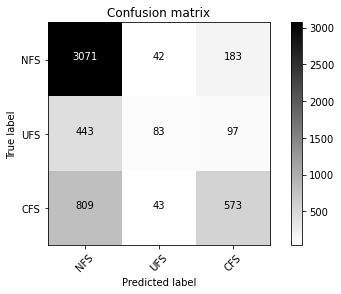

In [9]:
clf = svm.SVC(kernel='linear')

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"])